# Confounder example

Supporting notebook for the talk:

> What-if? Causal reasoning meets Bayesian Inference, presented at PyData Global 2022 by Benjamin T. Vincent 

In [1]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [2]:
%config InlineBackend.figure_format = 'retina'

## Data generating process

<Axes: >

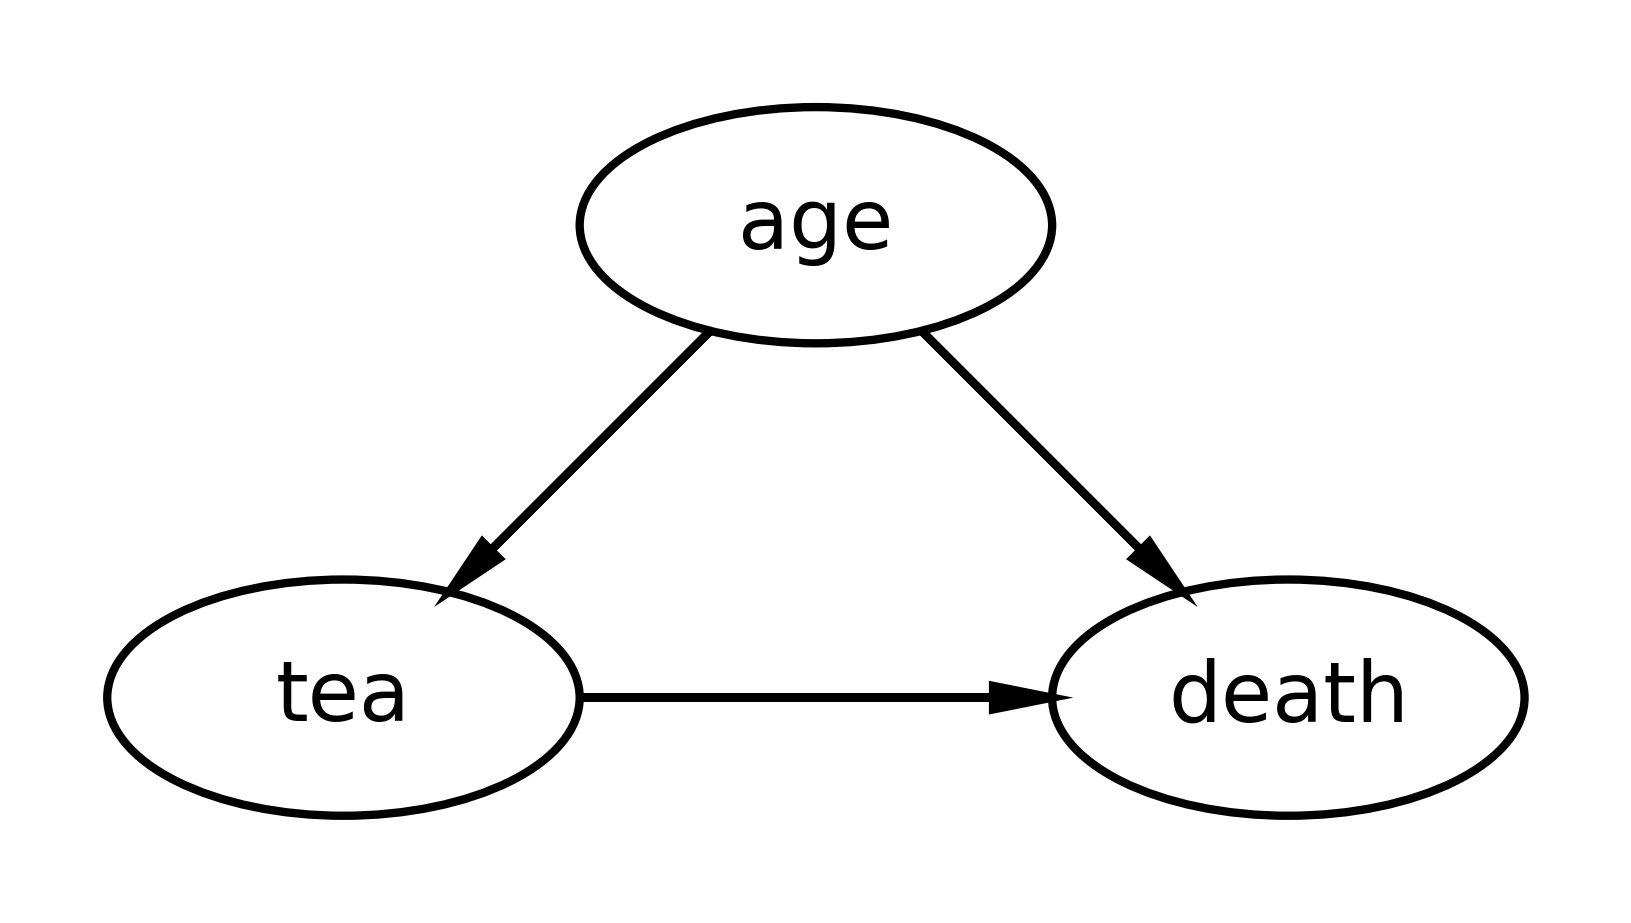

In [3]:
pgm = daft.PGM()

# outcome
pgm.add_node("age", "age", 0, 0, aspect=2)

# predictors
pgm.add_node("tea", "tea", -1, -1, aspect=2)
pgm.add_node("death", "death", 1, -1, aspect=2)

# add edges
pgm.add_edge("age", "tea")
pgm.add_edge("age", "death")
pgm.add_edge("tea", "death")

# print to screen and export
pgm.render(dpi=300)
# pgm.savefig("my_graph.png", dpi=300)

$$
\begin{aligned}
age & \sim \text{Uniform} (18, 90) \\
tea & \sim \text{Bernoulli}( \text{InverseLogit} ( 0.01 + 0.01 * age) ) \\
death & \sim \text{Bernoulli}(\text{InverseLogit} (\beta_0 + \beta_1 tea + \beta_2 age ))\\
\end{aligned}
$$

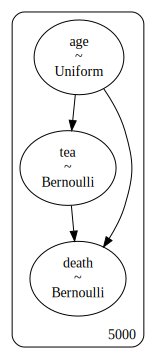

In [4]:
N = 5000

TEA_EFFECT = -0.5
DEATH_INTERCEPT = -5
DEATH_AGE_SLOPE = 0.2
TEA_INTERCEPT = 0.01
TEA_AGE_SLOPE = 0.1


def centered_age(age):
    return age - (90 - 18) / 2


def p_tea_given_age(age):
    return pm.math.invlogit(TEA_INTERCEPT + TEA_AGE_SLOPE * centered_age(age))


def p_death_given_age_and_tea(tea, age, TEA_EFFECT):
    return pm.math.invlogit(
        DEATH_INTERCEPT
        + TEA_EFFECT * tea
        + DEATH_AGE_SLOPE * centered_age(age)
    )


def p_death_given_age(age):
    """Only used for plotting"""
    return pm.math.invlogit(DEATH_INTERCEPT + DEATH_AGE_SLOPE * centered_age(age))


with pm.Model() as observational:
    age = pm.Uniform("age", 18, 90, size=N)
    tea = pm.Bernoulli("tea", p_tea_given_age(age))
    death = pm.Bernoulli(
        "death", p_death_given_age_and_tea(tea, age, TEA_EFFECT)
    )

pm.model_to_graphviz(observational)

In [5]:
# draw samples from this model
with observational:
    idata_obs = pm.sample_prior_predictive(samples=1)

Sampling: [age, death, tea]


In [6]:
plt.rc("font", size=16)

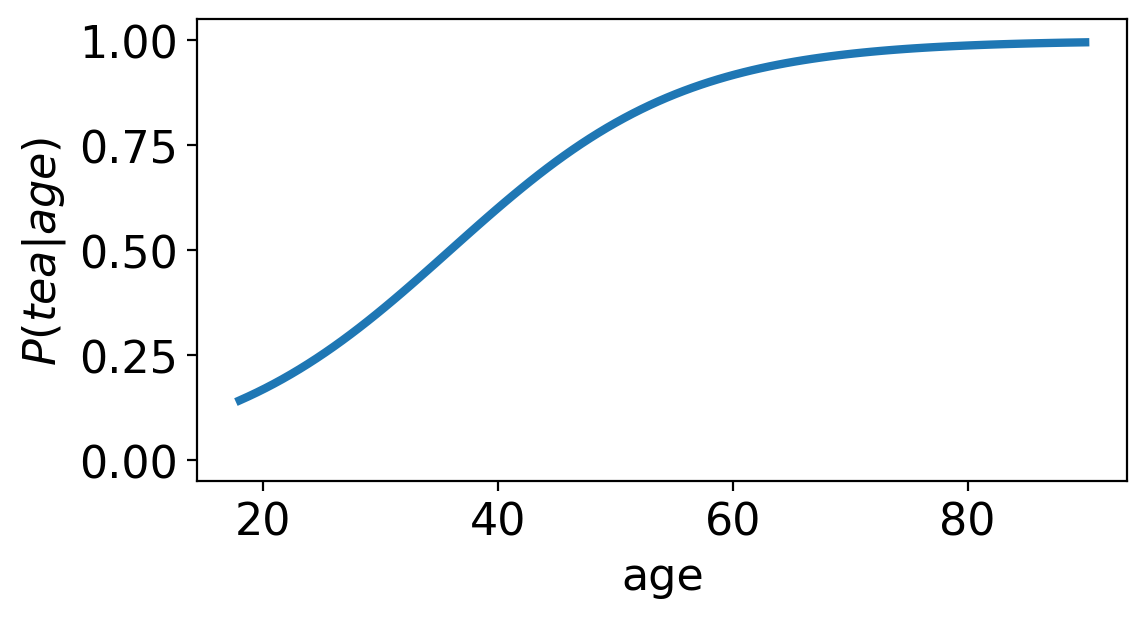

In [7]:
# Plot the true age -> tea relationship

fig, ax = plt.subplots(figsize=(6, 3))

_age = np.linspace(18, 90, 100)
_p_tea = p_tea_given_age(_age).eval()

ax.plot(_age, _p_tea, lw=3)
ax.set(xlabel="age", ylabel=r"$P(tea|age)$", ylim=[-0.05, 1.05])
plt.savefig("img/confound_tea_age.png", bbox_inches="tight")

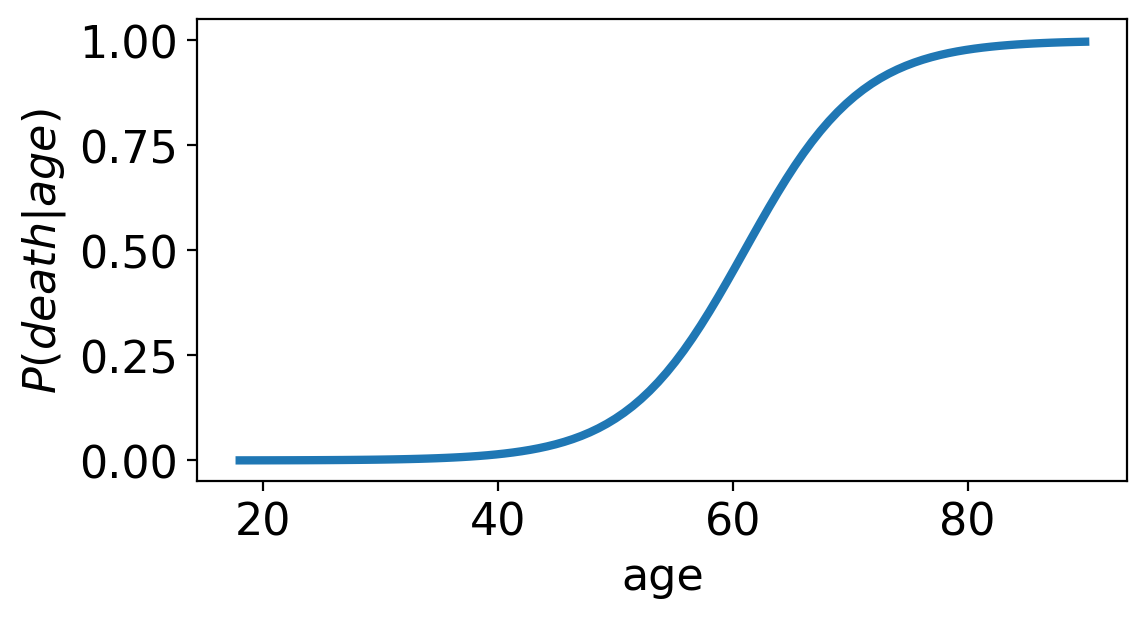

In [8]:
# Plot the true age -> death

fig, ax = plt.subplots(figsize=(6, 3))

_age = np.linspace(18, 90, 100)
_p_death = p_death_given_age(_age).eval()

ax.plot(_age, _p_death, lw=3)
ax.set(xlabel="age", ylabel=r"$P(death|age)$", ylim=[-0.05, 1.05])
plt.savefig("img/confound_age_death.png", bbox_inches="tight")

In [9]:
# extract variables from idata
tea = np.squeeze(az.extract(idata_obs, group="prior", var_names="tea").data)
death = np.squeeze(az.extract(idata_obs, group="prior", var_names="death").data)
age = np.squeeze(az.extract(idata_obs, group="prior", var_names="age").data)

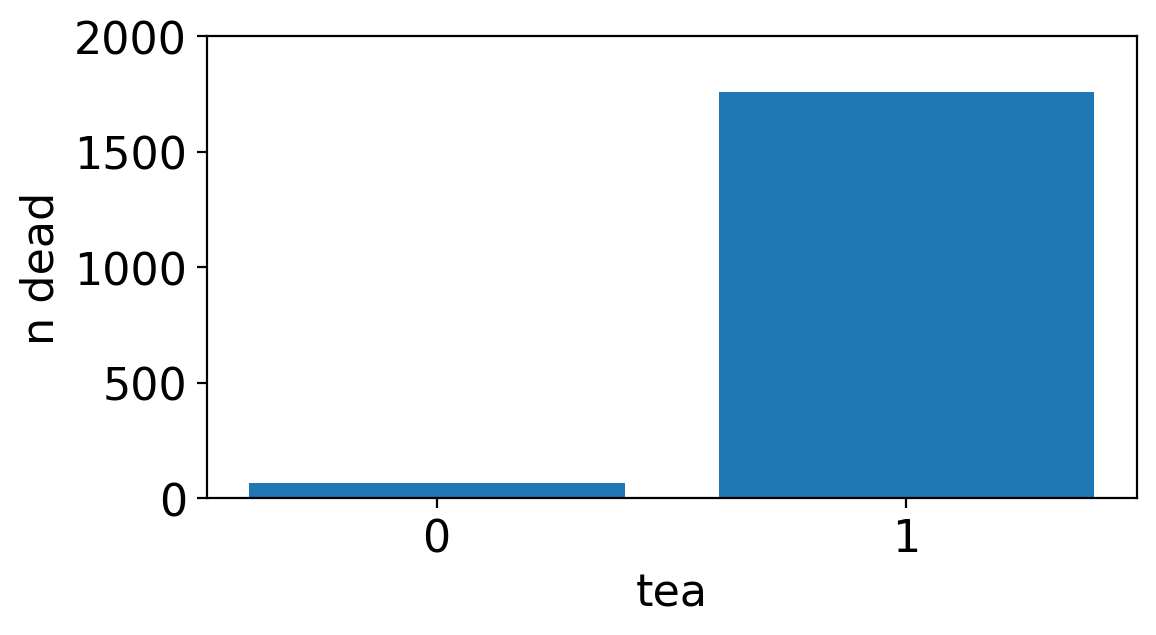

In [10]:
# plot number dead
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar([0, 1], [death[tea == 0].sum(), death[tea == 1].sum()])
ax.set(xticks=[0, 1], ylim=[0, 2000], xlabel="tea", ylabel="n dead")
plt.savefig("img/confound_death.png", bbox_inches="tight")

## Can we make good inferences in an observational trial _if_ we model the confounder?

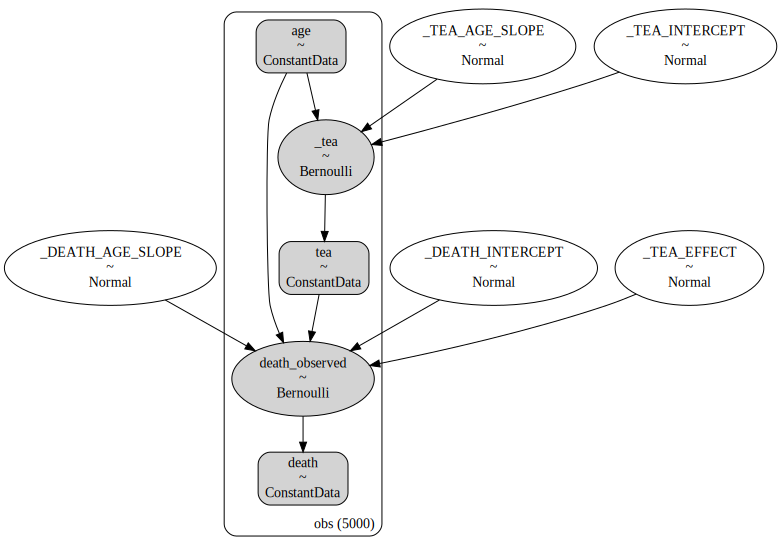

In [11]:
COORDS = {"obs": np.arange(N)}


with pm.Model(coords=COORDS) as model:
    age = pm.ConstantData("age", age, dims="obs")
    tea = pm.ConstantData("tea", tea, dims="obs")
    death = pm.ConstantData("death", death, dims="obs")

    _TEA_INTERCEPT = pm.Normal("_TEA_INTERCEPT", 0, 1.0)
    _TEA_AGE_SLOPE = pm.Normal("_TEA_AGE_SLOPE", 0, 1.0)
    _tea = pm.Bernoulli(
        "_tea",
        p=pm.math.invlogit(_TEA_INTERCEPT + _TEA_AGE_SLOPE * centered_age(age)),
        observed=tea,
        dims="obs",
    )

    _DEATH_INTERCEPT = pm.Normal("_DEATH_INTERCEPT", 0, 1.0)
    _TEA_EFFECT = pm.Normal("_TEA_EFFECT", 0, 1.0)
    _DEATH_AGE_SLOPE = pm.Normal("_DEATH_AGE_SLOPE", 0, 1.0)
    pm.Bernoulli(
        "death_observed",
        p=pm.math.invlogit(
            _DEATH_INTERCEPT + _TEA_EFFECT * tea + _DEATH_AGE_SLOPE * centered_age(age)
        ),
        observed=death,
        dims="obs",
    )


pm.model_to_graphviz(model)

In [12]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [_TEA_INTERCEPT, _TEA_AGE_SLOPE, _DEATH_INTERCEPT, _TEA_EFFECT, _DEATH_AGE_SLOPE]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


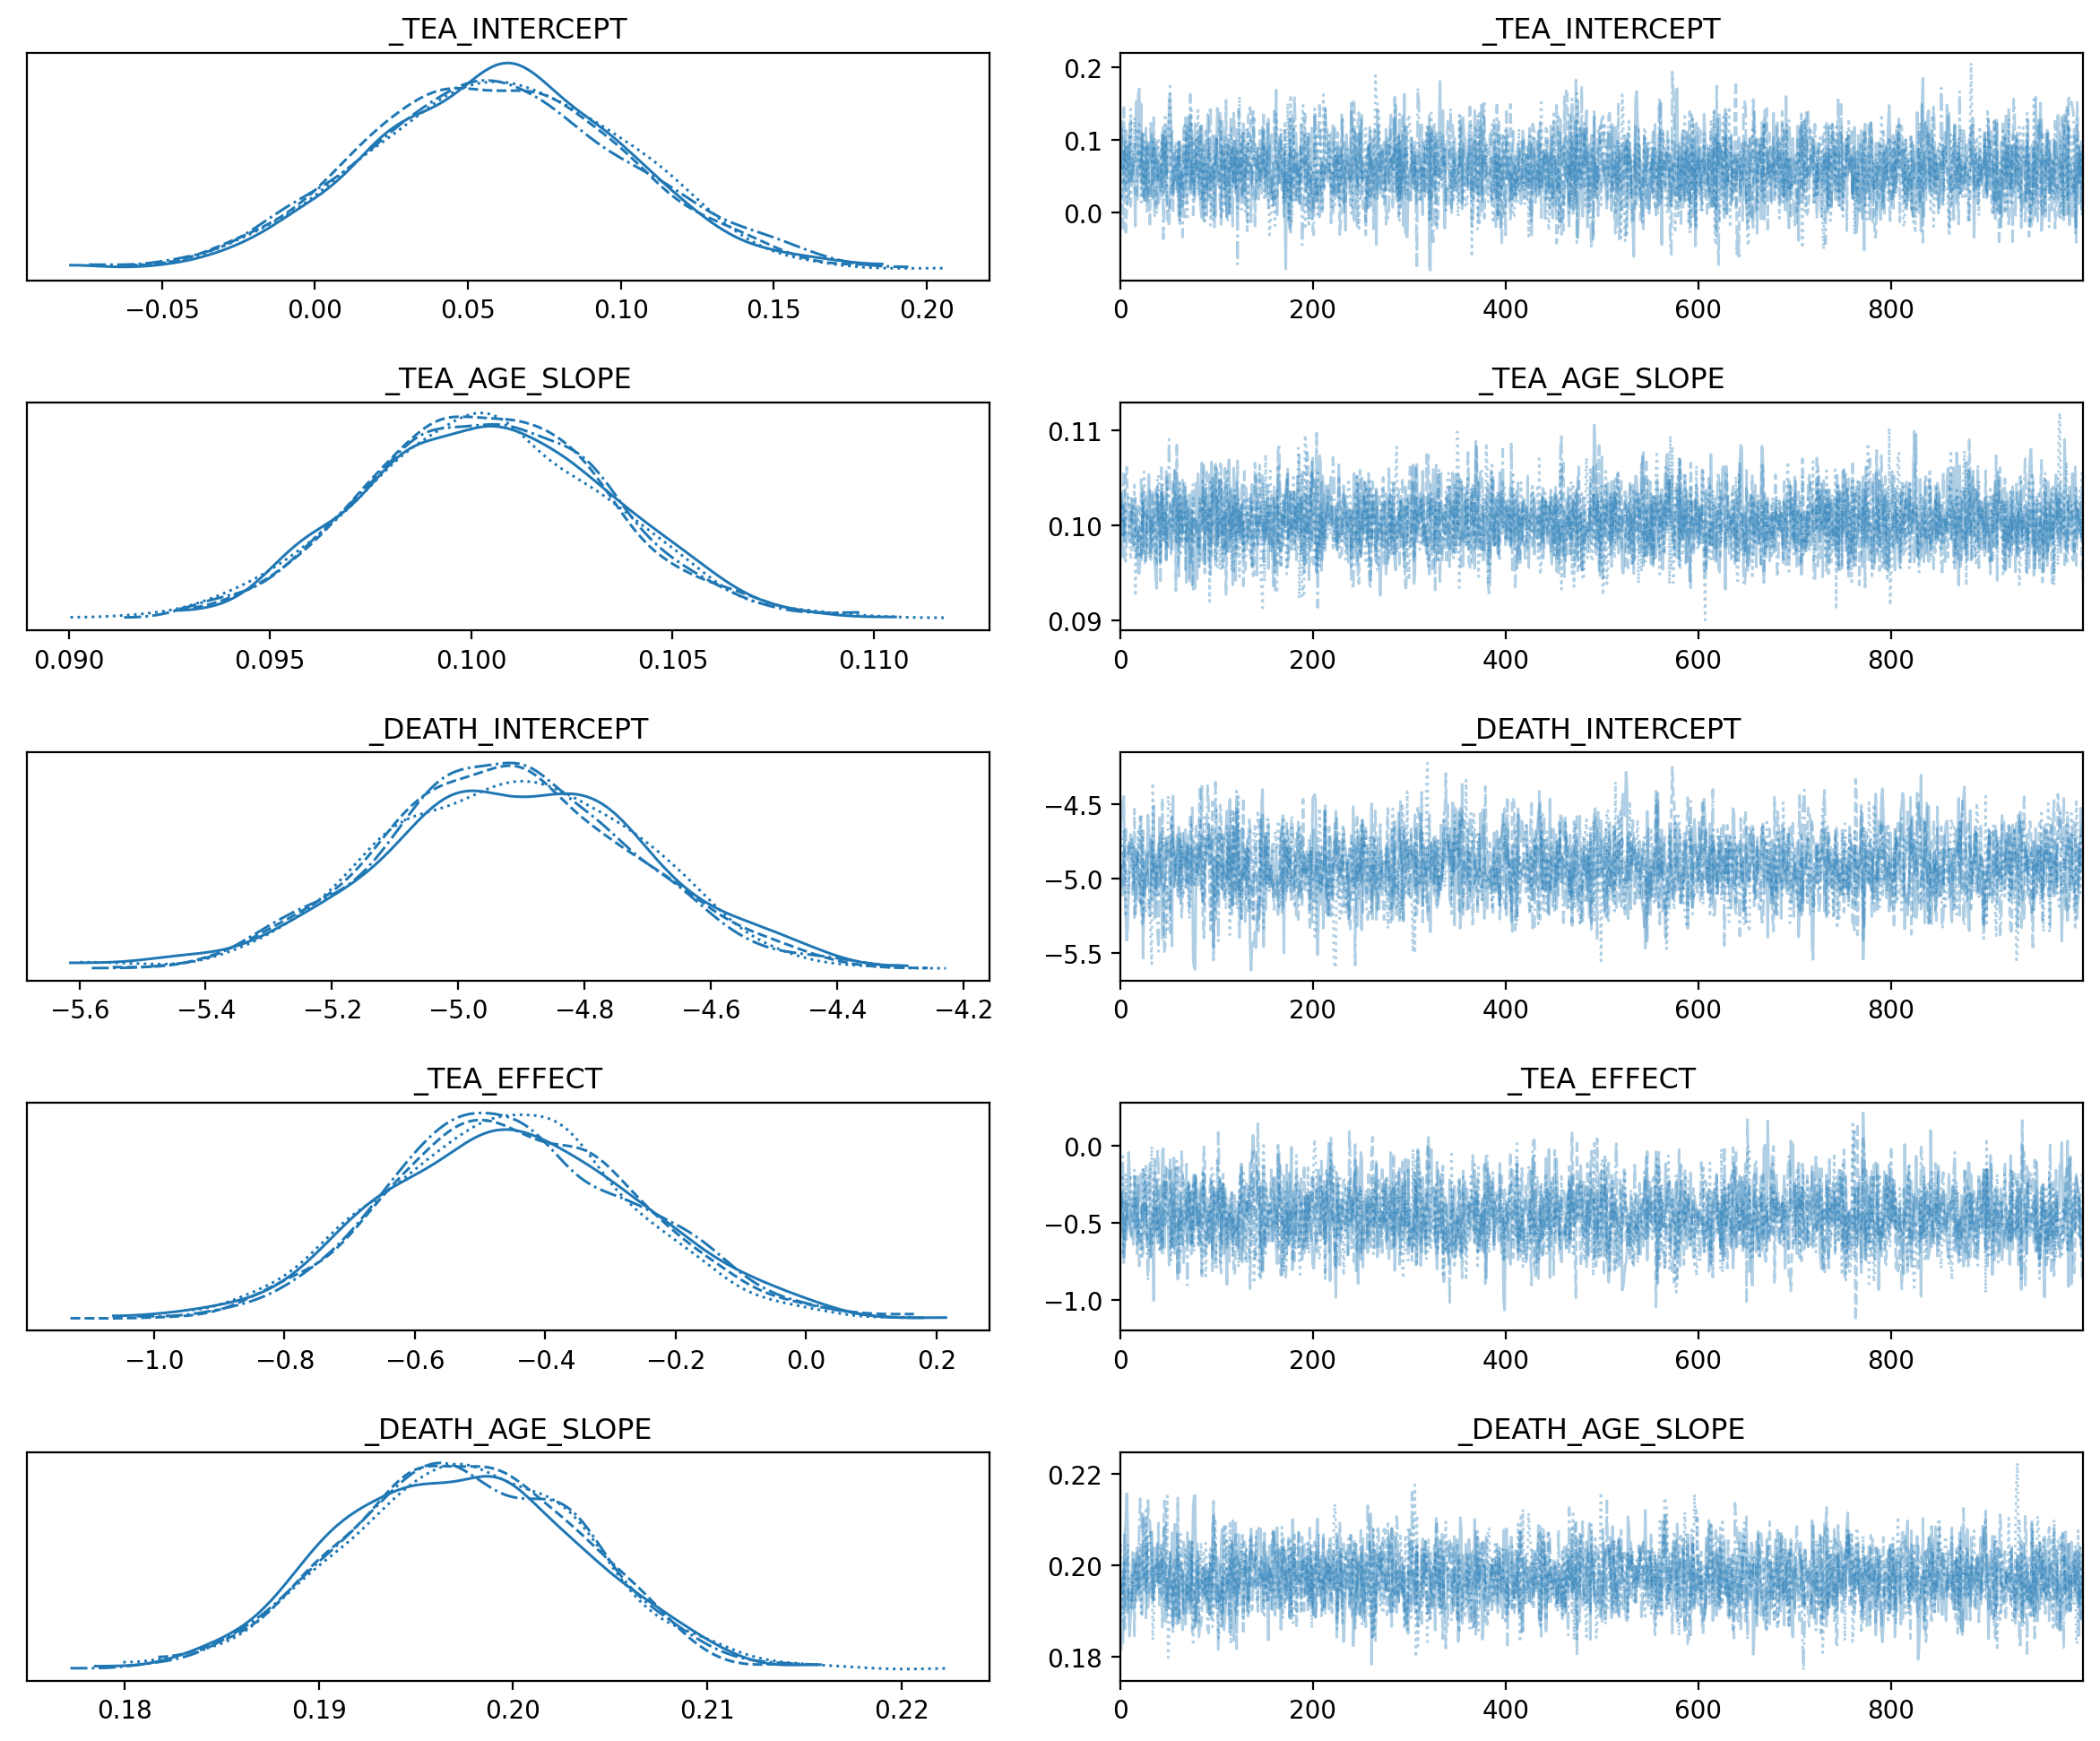

In [13]:
az.plot_trace(idata)
plt.tight_layout();

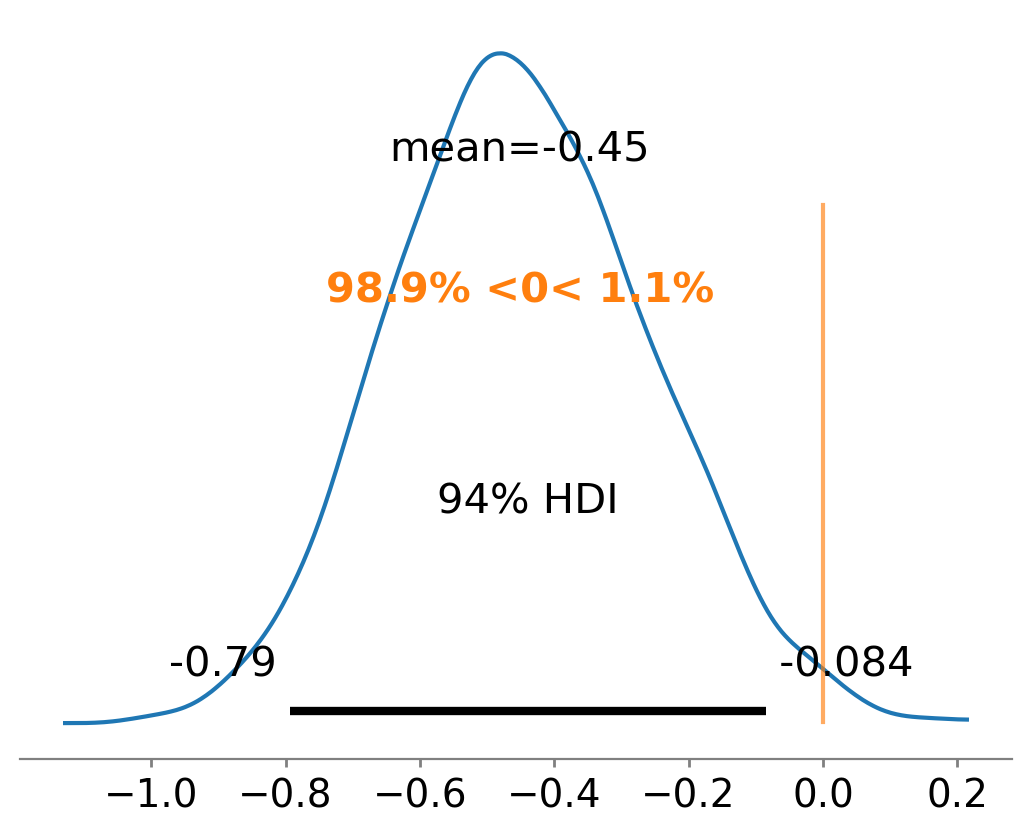

In [14]:
ax = az.plot_posterior(idata, var_names="_TEA_EFFECT", ref_val=0)
ax.set(title="")
plt.savefig("img/confound_TEA_EFFECT_estimate.png", bbox_inches="tight")

## Let's run a randomised control trial

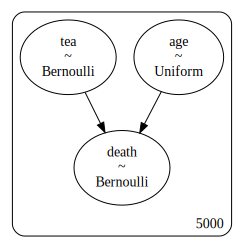

In [15]:
with pm.Model() as rct:
    age = pm.Uniform("age", 18, 90, size=N)
    tea = pm.Bernoulli("tea", 0.5, shape=N)
    death = pm.Bernoulli(
        "death", p_death_given_age_and_tea(tea, age, TEA_EFFECT)
    )

pm.model_to_graphviz(rct)

In [16]:
# draw samples from this model
with rct:
    idata_rct = pm.sample_prior_predictive(samples=1)

Sampling: [age, death, tea]


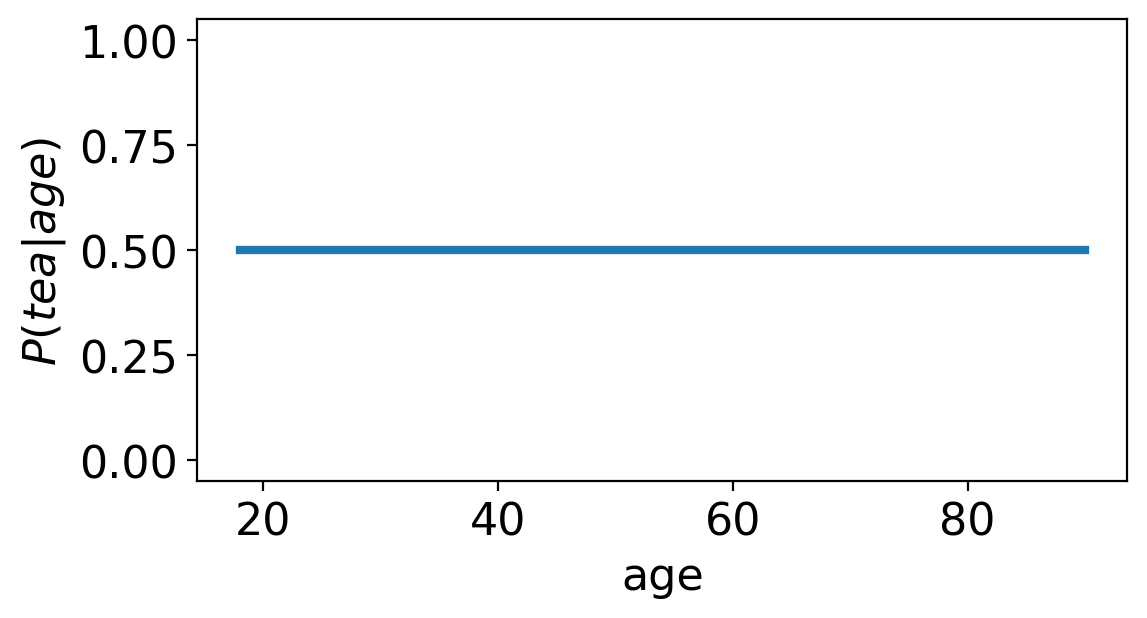

In [17]:
# Plot the true age -> tea relationship

fig, ax = plt.subplots(figsize=(6, 3))

_age = np.linspace(18, 90, 100)
_p_tea = np.ones(100) * 0.5

ax.plot(_age, _p_tea, lw=3)
ax.set(xlabel="age", ylabel=r"$P(tea|age)$", ylim=[-0.05, 1.05])
plt.savefig("img/confound_rct_tea_age.png", bbox_inches="tight")

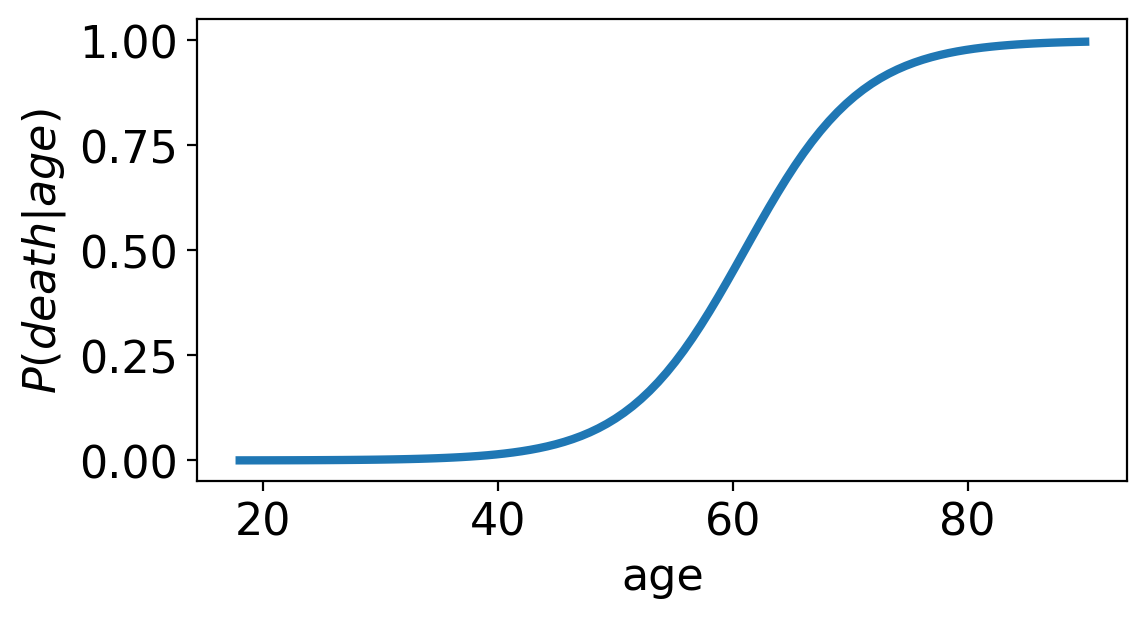

In [18]:
# Plot the true age -> death

fig, ax = plt.subplots(figsize=(6, 3))

_age = np.linspace(18, 90, 100)
_p_death = p_death_given_age(_age).eval()

ax.plot(_age, _p_death, lw=3)
ax.set(xlabel="age", ylabel=r"$P(death|age)$", ylim=[-0.05, 1.05])
plt.savefig("img/confound_rct_age_death.png", bbox_inches="tight")

In [19]:
# extract variables from idata
tea = az.extract(idata_rct, group="prior", var_names="tea").data
death = az.extract(idata_rct, group="prior", var_names="death").data
age = az.extract(idata_rct, group="prior", var_names="age").data

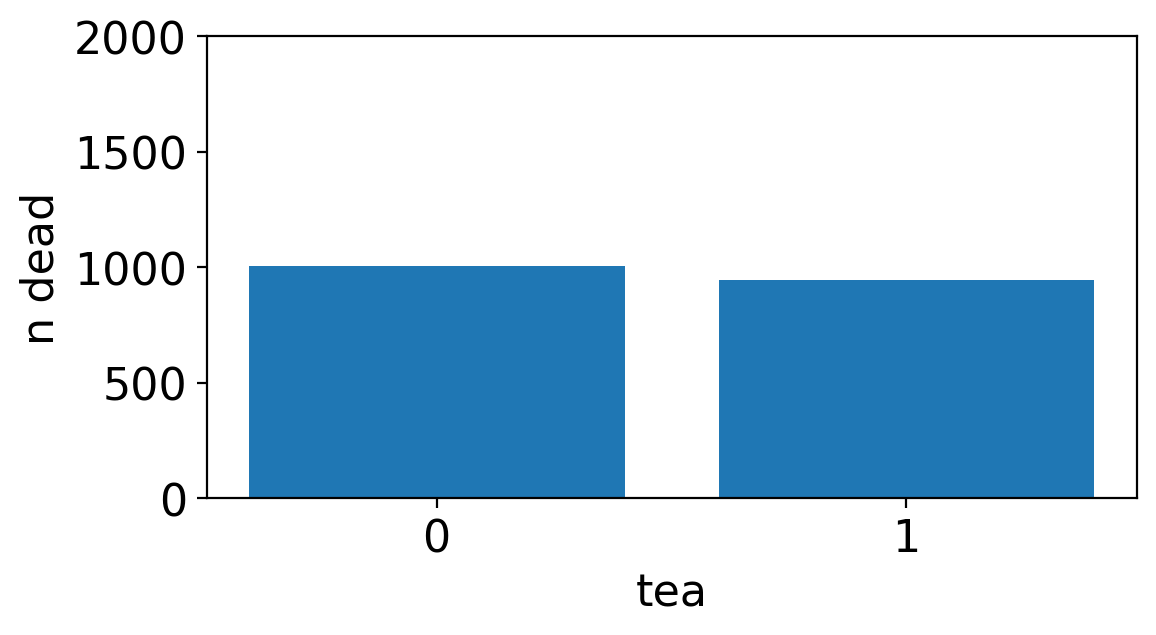

In [20]:
# plot number dead
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar([0, 1], [death[tea == 0].sum(), death[tea == 1].sum()])
ax.set(xticks=[0, 1], xlabel="tea", ylim=[0, 2000], ylabel="n dead")
plt.savefig("img/confound_rct_death.png", bbox_inches="tight")